In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

import numpy as np
from PIL import Image

import sys
import os

# Get path to the parent directory (i.e., project/)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from mtt import environment as env

from baseline_src.dataloaders import PrecondDataset
from baseline_src.models import UNetCompressor
from baseline_src.models import UNETPreSymbolicBottleneck
from baseline_src.models import SimilarityModel

from baseline_src.trainers import UNetTrainer
from baseline_src.trainers import SymbolicAttentionTrainer
from baseline_src.trainers import QnATrainer

from baseline_src.utils import visualize_gumbel_reconstructions

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
generator = env.ExampleGenerator(mode='precond')

# --- Model ---

unet_model = UNetCompressor(bottleneck_dim=128).cuda()

# --- Datasets and Loaders ---
train_dataset = PrecondDataset(generator, num_samples=50000, mode='img_train')
val_dataset   = PrecondDataset(generator, mode='img_val')

dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_val   = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
# Unet warmup

config = {
    'device': 'cuda',
    'patience': 5,
    'checkpoint_path': 'checkpoints/unet_compressor_best_unetpre.pth',
    'loss_fn': nn.MSELoss(),
    'lr': 1e-3,
    'optimizer': torch.optim.Adam(unet_model.parameters(), lr=1e-3)
}

trainer = UNetTrainer(
    model=unet_model,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val,
    config=config
)

trainer.train(num_epochs=3)


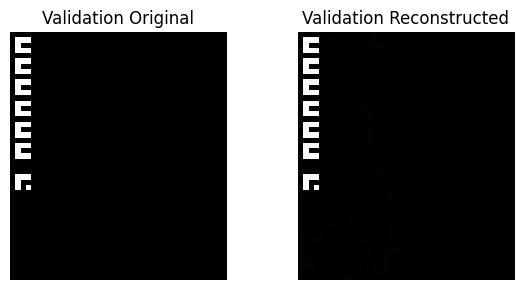

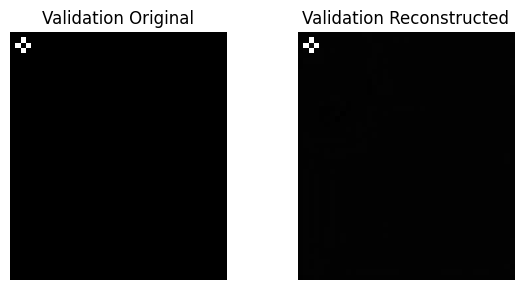

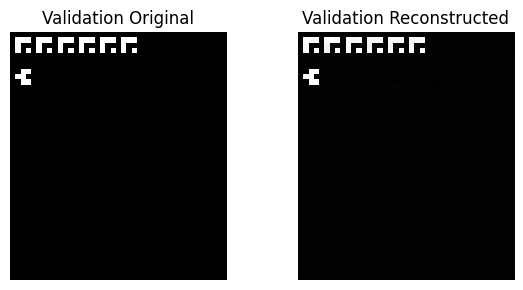

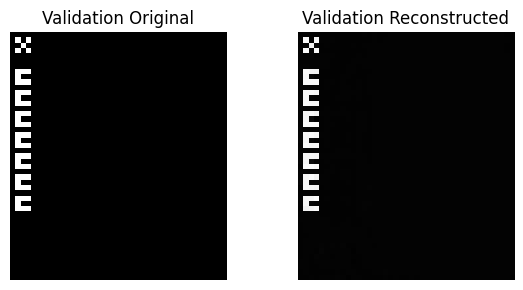

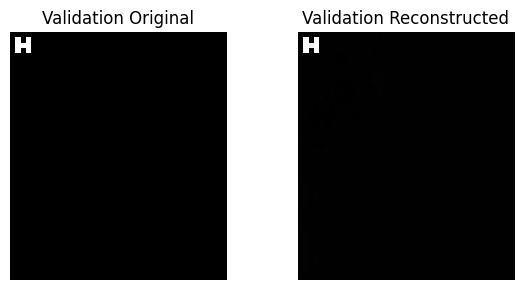

In [3]:
from baseline_src.utils import visualize_reconstructions_unet

# Load in UNET model if pretraining

unet_model.load_state_dict(torch.load("checkpoints/unet_compressor_best_unetpre.pth"))
unet_model.eval()

dataset = PrecondDataset(generator, num_samples=10, mode='img_val')
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

visualize_reconstructions_unet(unet_model, dataloader, num_examples=5, title_prefix="Validation")

In [4]:
# --- Model ---

symbolic_model = UNETPreSymbolicBottleneck(
    unet=unet_model,
    bottleneck_shape=(128, 5, 5),
    num_symbols=8,
    symbol_length=8
).cuda()

# Initialize optimizer and loss

trainable_params = list(symbolic_model.unet.parameters()) + \
                   list(symbolic_model.bottleneck_encoder.parameters()) + \
                   list(symbolic_model.decoder.parameters())


config = {
    "num_epochs": 100,
    "patience": 10,
    "save_path": "checkpoints/symbolic_unetpre_model_best.pth",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [ ]:
optimizer = torch.optim.Adam(symbolic_model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

# Train
trainer = SymbolicAttentionTrainer(
    model=symbolic_model,
    train_loader=dataloader_train,
    val_loader=dataloader_val,
    optimizer=optimizer,
    loss_fn=loss_fn,
    config=config
)
trainer.train()


[Image 1] Bottleneck symbols:     b7 b0 b7 b2 b4 b6 b0 b5

[Image 2] Bottleneck symbols:     b7 b7 b7 b2 b4 b6 b0 b5

[Image 3] Bottleneck symbols:     b7 b2 b7 b2 b0 b6 b0 b5

[Image 4] Bottleneck symbols:     b7 b7 b5 b2 b0 b6 b0 b5

[Image 5] Bottleneck symbols:     b1 b1 b5 b0 b0 b0 b0 b5



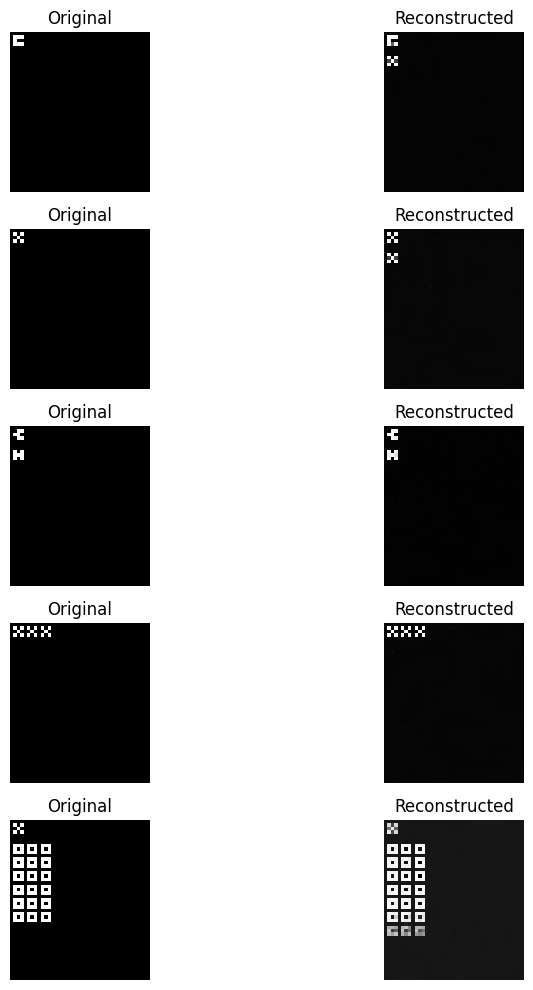

In [5]:
from baseline_src.utils import visualize_img_reconstruction

checkpoint = torch.load("checkpoints/symbolic_unetpre_model_best.pth", map_location=device)
symbolic_model.load_state_dict(checkpoint['model_state'])
start_epoch = checkpoint.get('epoch', 0)

visualize_img_reconstruction(symbolic_model, dataloader_val, device="cuda", num_examples=5)

In [6]:
# --- Dataloaders ---

generator = env.ExampleGenerator(mode='precond')

train_dataset = PrecondDataset(generator, num_samples=10000, mode='qna_train')
val_dataset = PrecondDataset(generator, mode='qna_val')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Models ---

unet_model = UNetCompressor(bottleneck_dim=128).cuda()

answer_model = SimilarityModel(latent_dim=128).to(device)

symbolic_model = UNETPreSymbolicBottleneck(
    unet=unet_model,
    bottleneck_shape=(128, 5, 5),
    num_symbols=8,
    symbol_length=8
).cuda()

checkpoint = torch.load("checkpoints/symbolic_unetpre_model_best.pth", map_location=device)
symbolic_model.load_state_dict(checkpoint['model_state'])
start_epoch = checkpoint.get('epoch', 0)

print(f"✅ Loaded model from epoch {start_epoch}")

symbolic_model_set = [symbolic_model.bottleneck_encoder,
                      symbolic_model.decoder,
                      symbolic_model.unet]

# --- Freeze or unfreeze parts of the model as needed add params to list ---

symbolic_model_params = []

for model in symbolic_model_set:
    params = model.parameters()
    for param in params:
        param.requires_grad = True  # or False if you want to freeze
    
    symbolic_model_params += list(params)

#answer_optimizer = optim.Adam(answer_model.parameters(), lr=1e-3)
answer_optimizer = optim.Adam(list(answer_model.parameters()) + symbolic_model_params, lr=1e-3)

criterion = nn.CrossEntropyLoss()

✅ Loaded model from epoch 35


[Image 1] Bottleneck symbols:     b7 b2 b5 b3 b1 b0 b0 b5

[Image 2] Bottleneck symbols:     b4 b1 b7 b0 b0 b4 b0 b1

[Image 3] Bottleneck symbols:     b1 b1 b3 b0 b2 b2 b3 b1

[Image 4] Bottleneck symbols:     b0 b2 b7 b0 b2 b7 b0 b4

[Image 5] Bottleneck symbols:     b0 b1 b5 b0 b0 b2 b0 b4



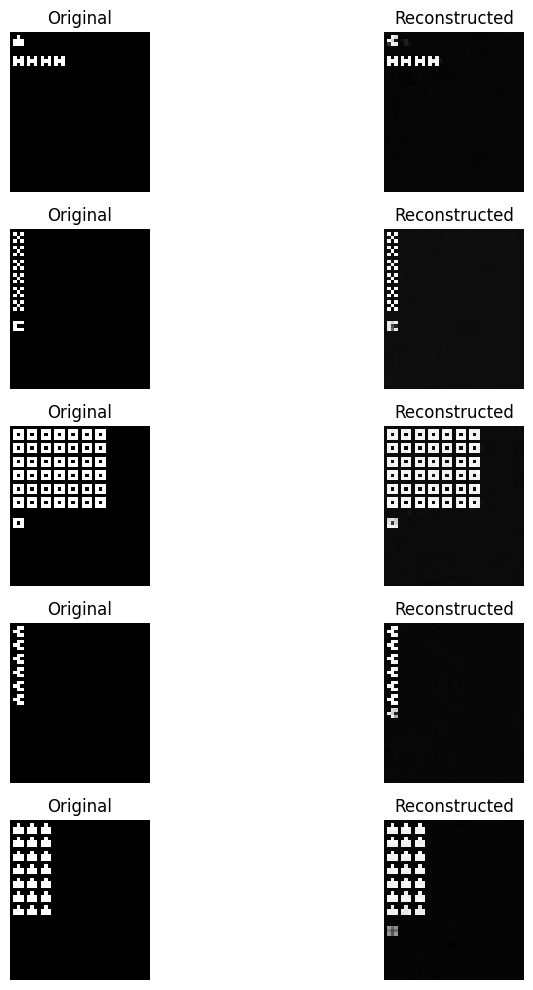

In [7]:
# --- Sanity check that the symbolic model is working ---

check_recon = PrecondDataset(generator, mode='img_val')
check_recon_loader = DataLoader(check_recon, batch_size=32, shuffle=False)

visualize_img_reconstruction(symbolic_model, check_recon_loader, device="cuda", num_examples=5)


In [ ]:
config = {
    "num_epochs": 10,
    "patience": 2,
    "save_path": "checkpoints/best_unet_similarity_model_unfrozen.pth",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

trainer = QnATrainer(
    answer_model=answer_model,
    symbolic_model=symbolic_model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    criterion=criterion,
    optimizer=answer_optimizer,
    config=config
)

trainer.train()


In [8]:
import random

# Set random seed for practice / Test evaluation

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

In [11]:
from baseline_src.dataloaders import PracTestDataset

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

answer_model = SimilarityModel(latent_dim=128).to(device)
answer_optimizer = optim.Adam(answer_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

answer_model.load_state_dict(torch.load("checkpoints/best_unet_similarity_model_unfrozen.pth")) # best_unet_similarity_model_unfrozen.pth
answer_model.train()

# --- Practice loop for qna model using inputs from symbolic_model  ---

# --- Practice Question Dataloader ---

quiz_generator = quiz_generator = env.QuizGeneratorML()
prac_dataset = PracTestDataset(quiz_generator=quiz_generator, mode='qna_prac')
practice_loader = DataLoader(prac_dataset, batch_size=2)

# Codes for in vs out of distribution testing

prac_logger = env.EvalLogger('precond', 'practice') # input precond -> practice, or practice -> test
prac_loss = 0

for img, questions, answer, program, options in tqdm(practice_loader, desc=f"Practice Run"):
    
    img, questions, answer = img.to(device), questions.to(device), answer.to(device)
    img_recon, symbols = symbolic_model(img, hard=True)
    
    logits = answer_model(img_recon, questions)
    loss = criterion(logits, answer)

    answer_optimizer.zero_grad()
    loss.backward()
    answer_optimizer.step()

    prac_loss += loss.item()
    prediction = logits.argmax(dim=1)
    
    # Pass batch inputs into qna tester
    prac_logger.test_qna(answer.cpu(), prediction.cpu(), program, options)


results_dict= prac_logger.return_results()
torch.save(answer_model.state_dict(), "checkpoints/best_unet_similarity_model_unfrozen.pth") # test_unet_similarity_model_unfrozen.pth

print(f"Practice Loss={prac_loss:.4f}, Practice Acc={results_dict['accuracy']:.4f}")

print('Number logged: ', [k + ':' + str(v)[:4] for k,v in results_dict['logging_dict'].items()])
print('Number correct: ', [k + ':' + str(v)[:4] for k,v in results_dict['correct_dict'].items()])
print('Accuracy: ', [k + ':' + str(v)[:4] for k,v in results_dict['accuracy_dict'].items()])


Practice Run: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 114.53it/s]

Practice Loss=45.4224, Practice Acc=0.8400
Number logged:  ['ood_symbol_question:47', 'ood_number_question:31', 'ood_both_question:16', 'ood_symbol_answer:57', 'ood_number_answer:41', 'ood_both_answer:20']
Number correct:  ['ood_symbol_question:39', 'ood_number_question:23', 'ood_both_question:13', 'ood_symbol_answer:50', 'ood_number_answer:33', 'ood_both_answer:17']
Accuracy:  ['ood_symbol_question:0.82', 'ood_number_question:0.74', 'ood_both_question:0.81', 'ood_symbol_answer:0.87', 'ood_number_answer:0.80', 'ood_both_answer:0.85']


In [12]:
import pickle 

# Path to save the pickle file
file_path = os.path.join('results', 'symbolic_unetpre_unfrozen_results_practice.pkl')

# Save the dictionary
with open(file_path, 'wb') as f:
    pickle.dump(results_dict, f)

print(f"Dictionary saved to {file_path}")

Dictionary saved to results/symbolic_unetpre_unfrozen_results_practice.pkl


[Image 1] | Program: B12*12 | Questions: ['B12*12', 'B11*12', 'AC+AB', 'B12*2']
[Image 1] Bottleneck symbols:     btensor([[0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]], device='cuda:0')



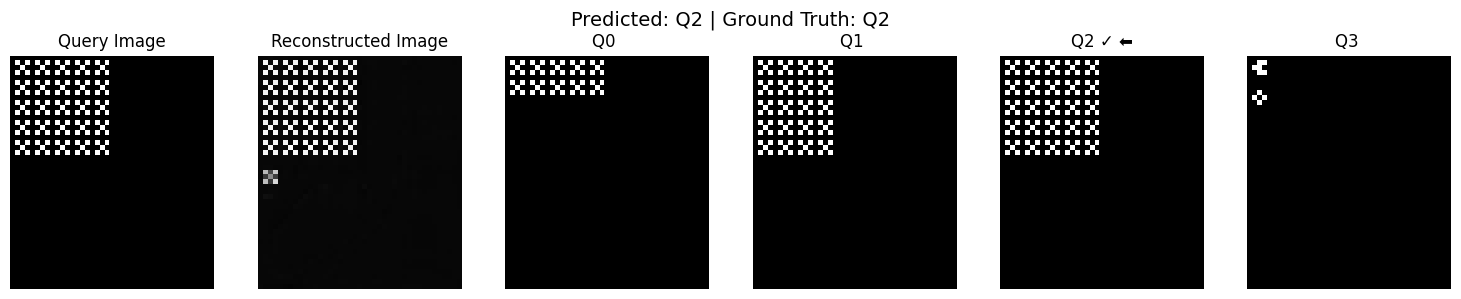

In [13]:
from baseline_src.utils import visualize_qna_prediction

answer_model.eval()

 # --- Feeze or unfreeze parts of the model as needed ---
params = answer_model.encoder.parameters()

for param in params:
    param.requires_grad = False  # or False if you want to freeze

    
visualize_qna_prediction(answer_model, symbolic_model, prac_dataset, device=device)

In [15]:
# --- Test loop for qna model using inputs from symbolic_model ---
# --- Test Question Dataloader ---

quiz_generator = quiz_generator = env.QuizGeneratorML()
test_dataset = PracTestDataset(quiz_generator=quiz_generator, mode='qna_test')

test_loader = DataLoader(test_dataset, batch_size=1)

answer_model.eval()
test_correct = 0

practice_codes = set(env.ShapeLibrary(mode='practice').shape_codes)
practice_numbers = set(env.NumberLibrary(mode='practice').numbers)

test_codes = set(env.ShapeLibrary(mode='test').shape_codes)
new_test_codes = list(test_codes.difference(practice_codes))

test_numbers = set(env.NumberLibrary(mode='test').numbers)
new_test_numbers = list(test_numbers.difference(practice_numbers))

test_logger = env.EvalLogger('practice', 'test') # input precond -> practice, or practice -> test

with torch.no_grad():

    for img, questions, answer, program, options in tqdm(test_loader, desc=f"Testing..."):

        img, questions, answer = img.to(device), questions.to(device), answer.to(device)
        img_recon, symbols = symbolic_model(img, hard=True)
        
        logits = answer_model(img_recon, questions)
        prediction = logits.argmax(dim=1)
        
        test_logger.test_qna(answer.cpu(), prediction.cpu(), program, options)


results_dict = test_logger.return_results()
    
print(f"Test Acc={results_dict['accuracy']:.4f}")

print('Number logged: ', [k + ':' + str(v)[:4] for k,v in results_dict['logging_dict'].items()])
print('Number correct: ', [k + ':' + str(v)[:4] for k,v in results_dict['correct_dict'].items()])
print('Accuracy: ', [k + ':' + str(v)[:4] for k,v in results_dict['accuracy_dict'].items()])


Testing...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 265.07it/s]

Test Acc=0.6700
Number logged:  ['ood_symbol_question:45', 'ood_number_question:26', 'ood_both_question:13', 'ood_symbol_answer:64', 'ood_number_answer:34', 'ood_both_answer:22']
Number correct:  ['ood_symbol_question:23', 'ood_number_question:7', 'ood_both_question:4', 'ood_symbol_answer:37', 'ood_number_answer:13', 'ood_both_answer:8']
Accuracy:  ['ood_symbol_question:0.51', 'ood_number_question:0.26', 'ood_both_question:0.30', 'ood_symbol_answer:0.57', 'ood_number_answer:0.38', 'ood_both_answer:0.36']


[Image 1] | Program: AC+BA12 | Questions: ['AC+BA12', 'AC+BA11', 'AC+BA2', 'CA']
[Image 1] Bottleneck symbols:     btensor([[0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')



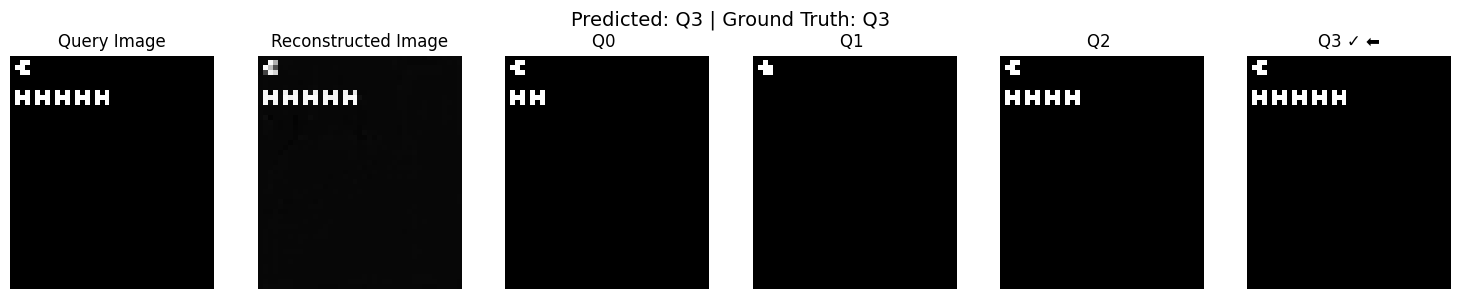

[Image 1] | Program: B10*10+A | Questions: ['B10*10+A', 'AB10*10', 'A*2+AC10', 'B20*10+A']
[Image 1] Bottleneck symbols:     btensor([[0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]], device='cuda:0')



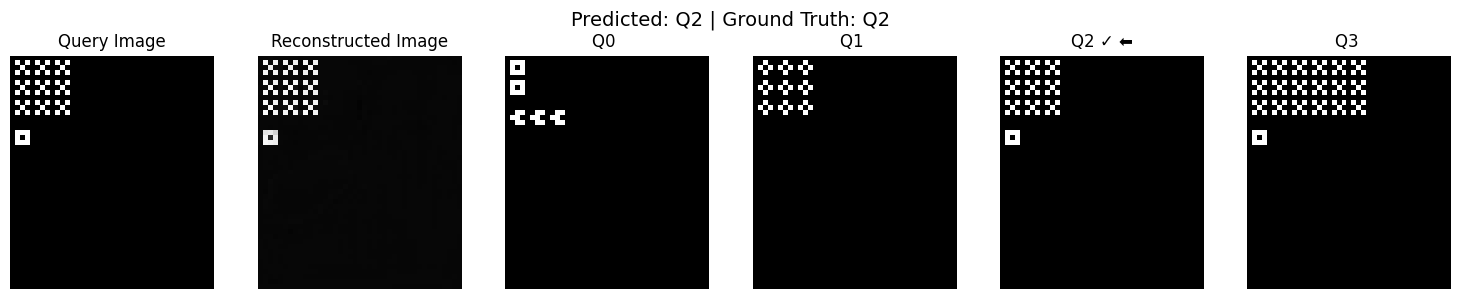

[Image 1] | Program: B*12 | Questions: ['B*12', 'AC*2', 'C*2', 'A10*22']
[Image 1] Bottleneck symbols:     btensor([[0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.]], device='cuda:0')



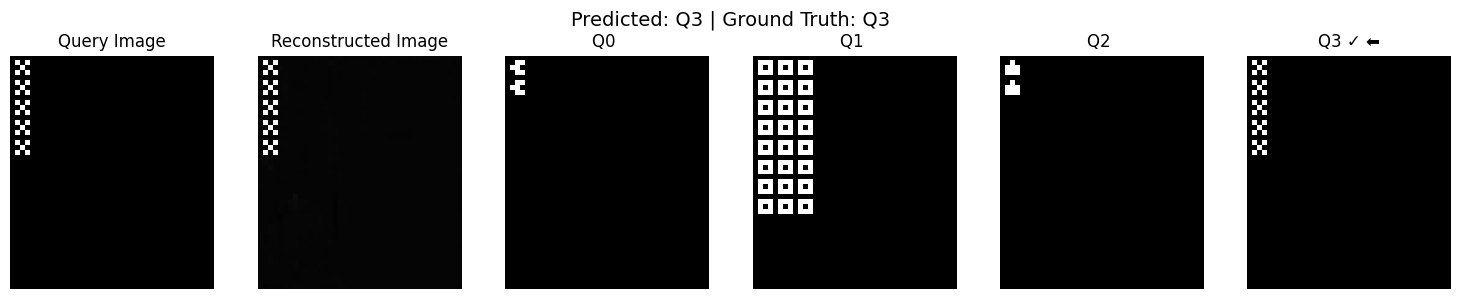

In [16]:
for i in range(3):
    visualize_qna_prediction(answer_model, symbolic_model, test_dataset, device=device)
    

In [ ]:
import pickle 

# Path to save the pickle file
file_path = os.path.join('results', 'symbolic_unetpre_unfrozen_results_test.pkl')

# Save the dictionary
with open(file_path, 'wb') as f:
    pickle.dump(results_dict, f)

print(f"Dictionary saved to {file_path}")

In [ ]:
answer